## Data Wrangling

The objectives of this stage are as follows:
    
**1) Exploring and understanding the data**

        a) What do various fields represent ? 
        b) Which variables are numerical, categorical, boolean etc.
        c) Looking at summary statistics

**2) Cleaning the data and imputing missing values where possible**

**3) Organizing the data and making it ready for the EDA stage**


In [10]:
from pathlib import Path

# uncomment and run below if you need to pip install the pandas-profiling library
#import sys
#!{sys.executable} -m pip install -U pandas-profiling==2.9.0
#!jupyter nbextension enable --py widgetsnbextension

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
from pandas_profiling.utils.cache import cache_file
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sb_utils import save_file
from collections import defaultdict
from collections import Counter


The below steps import the data and understand it using the pandas profiling tool. 

In [11]:
raw_data_file = "Raw_data/train.csv"

df_all = pd.read_csv(raw_data_file)

df_all.head()


customer_ID  shopping_pt  record_type  day   time state  location  \
0     10000000            1            0    0  08:35    IN     10001   
1     10000000            2            0    0  08:38    IN     10001   
2     10000000            3            0    0  08:38    IN     10001   
3     10000000            4            0    0  08:39    IN     10001   
4     10000000            5            0    0  11:55    IN     10001   

   group_size  homeowner  car_age  ... C_previous  duration_previous  A  B  C  \
0           2          0        2  ...        1.0                2.0  1  0  2   
1           2          0        2  ...        1.0                2.0  1  0  2   
2           2          0        2  ...        1.0                2.0  1  0  2   
3           2          0        2  ...        1.0                2.0  1  0  2   
4           2          0        2  ...        1.0                2.0  1  0  2   

   D  E  F  G  cost  
0  2  1  2  2   633  
1  2  1  2  1   630  
2  2  1  2  1   630  
3  2  1  2  1   630  
4  2  1  2  1   630  

[5 rows x 25 columns]

There are lots of columns and all are not visible. So let's transpose the head and take a better look.

In [15]:
df_all.head(12).T

0         1         2         3         4         5   \
customer_ID        10000000  10000000  10000000  10000000  10000000  10000000   
shopping_pt               1         2         3         4         5         6   
record_type               0         0         0         0         0         0   
day                       0         0         0         0         0         0   
time                  08:35     08:38     08:38     08:39     11:55     11:57   
state                    IN        IN        IN        IN        IN        IN   
location              10001     10001     10001     10001     10001     10001   
group_size                2         2         2         2         2         2   
homeowner                 0         0         0         0         0         0   
car_age                   2         2         2         2         2         2   
car_value                 g         g         g         g         g         g   
risk_factor             3.0       3.0       3.0       3.0       3.0       3.0   
age_oldest               46        46        46        46        46        46   
age_youngest             42        42        42        42        42        42   
married_couple            1         1         1         1         1         1   
C_previous              1.0       1.0       1.0       1.0       1.0       1.0   
duration_previous       2.0       2.0       2.0       2.0       2.0       2.0   
A                         1         1         1         1         1         1   
B                         0         0         0         0         0         0   
C                         2         2         2         2         2         2   
D                         2         2         2         2         2         2   
E                         1         1         1         1         1         1   
F                         2         2         2         2         2         2   
G                         2         1         1         1         1         1   
cost                    633       630       630       630       630       638   

                         6         7         8         9         10        11  
customer_ID        10000000  10000000  10000000  10000005  10000005  10000005  
shopping_pt               7         8         9         1         2         3  
record_type               0         0         1         0         0         0  
day                       0         0         0         3         3         3  
time                  11:58     12:03     12:07     08:56     08:56     08:57  
state                    IN        IN        IN        NY        NY        NY  
location              10001     10001     10001     10006     10006     10006  
group_size                2         2         2         1         1         1  
homeowner                 0         0         0         0         0         0  
car_age                   2         2         2        10        10        10  
car_value                 g         g         g         e         e         e  
risk_factor             3.0       3.0       3.0       4.0       4.0       4.0  
age_oldest               46        46        46        28        28        28  
age_youngest             42        42        42        28        28        28  
married_couple            1         1         1         0         0         0  
C_previous              1.0       1.0       1.0       3.0       3.0       3.0  
duration_previous       2.0       2.0       2.0      13.0      13.0      13.0  
A                         1         1         1         1         1         1  
B                         0         0         0         1         1         1  
C                         2         2         2         3         3         3  
D                         2         2         2         3         3         3  
E                         1         1         1         1         1         1  
F                         2         2         2         0         0         0 

In [16]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 665249 entries, 0 to 665248
Data columns (total 25 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   customer_ID        665249 non-null  int64  
 1   shopping_pt        665249 non-null  int64  
 2   record_type        665249 non-null  int64  
 3   day                665249 non-null  int64  
 4   time               665249 non-null  object 
 5   state              665249 non-null  object 
 6   location           665249 non-null  int64  
 7   group_size         665249 non-null  int64  
 8   homeowner          665249 non-null  int64  
 9   car_age            665249 non-null  int64  
 10  car_value          663718 non-null  object 
 11  risk_factor        424831 non-null  float64
 12  age_oldest         665249 non-null  int64  
 13  age_youngest       665249 non-null  int64  
 14  married_couple     665249 non-null  int64  
 15  C_previous         646538 non-null  float64
 16  du

The data file is quite large in size, about 130Mb. Let's create the profile report and **save it to a file**, so it can be accessed later without having to re-run the report.

In [5]:

profile_report = df_all.profile_report(sort='None', html={'style':{'full_width': True}}, progress_bar=False)
profile_report


In [6]:
profile_report = df_all.profile_report(html={'style': {'full_width': True}})
profile_report.to_file("Allstate_Raw_data_profile.html")


C:\Users\amite\Anaconda3\lib\site-packages\scipy\stats\stats.py:4812: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


## Data Profiling - Variables and their types

The categorization of the 25 variables by the profiling tool doesn't seem intuitively correct. For e.g. the day values (0-6) are used to represent Monday-Sunday, so are not real numbers, they are just categorical. Let's look at all variables one by one and decide how we should treat them.
   
1) **customer_ID**: The ID is an eight digit number with 97009 distinct values, one for each customer. We shall treat it as the ***index***

2) **shopping_pt**: This represents the quote number and has values ranging from 1 to 13. Values 1 to 3 occur 97009 times each, so it means all customers take atleast 3 quotes. While we can look at summary statistics to understand mean and median no. of quotes, for EDA purposes, this variable is ***categorical*** as it takes only distinct values.

3) **record_type**: Signals the difference between a 'shopping' quote and the 'final purchase' quote. 0=shopping point, 1=purchase point. Shall treat it as ***boolean***

4) **day**: The day values (0-6) are used to represent Monday-Sunday, so are not real numbers. They have 7 distinct values, so we will treat them as **categorical** 

5) **time**: Time of day (HH:MM). 1204 distinct values, pretty close to 1440, the total minutes in a day! We shall treat this as ***datetime***

6) **state**: State where shopping point occurred. This is clearly ***categorical***.

7) **location**: These are masked zip codes where shopping point occurred, so we will treat them as***categorical***.

8) **group_size**: This represents the total persons for whom the policy is being taken. It can only take distinct values and ranges from 1 to 4. We shall treat it as ***categorical***.

9) **homeowner**: Indicates if a person owns a home or not. Should be treated as ***boolean***

10) **car_age**: This represents how old the car is and is clearly ***numerical***.

11) **car_value**: This is supposed to be the price of the car when newly bought, but has values 'a' to 'g', so seems masked. We shall analyse it to see if 'a' to 'g' represents increasing values or not. ***??***

12) **risk_factor**: Each customer is categorized into one of 4 types, from 1 to 4. As of now, no way of knowing if 4 is riskier than 1. So keep it ***categorical.*** for now.

13 and 14) **age_oldest** and **age_youngest**: Age of oldest and youngest member in the group. Treat them as ***numerical***.

15) **married_couple**: Has boolean values 0 and 1, we shall treat it as ***boolean***

16) **C_previous**: What the customer formerly had or currently has for product option C (0=nothing, 1, 2, 3,4). So ***categorical*** feature.

17) **duration_previous**: The no. of years previous policy was in force, so ***numerical.***

18 to 24) **Product Vectors**: These are different values of product features A to G. They are the target variables, but take distinct values. So we will treat them as ***categorical.***

25) **cost**: The policy cost, is a continuous number, so ***numerical.***

In summary, there are:
    
**5 numerical variables**: car_age, age_oldest and age_youngest, duration_previous & cost.
    
**3 boolean variables**: record_type, homeowner, married_couple
    
**1 datetime**: time
    
**13 categorical variables**: shopping_pt, day, state, location, group_size, risk_factor, C_previous and 7 products vectors A to G.

**1 undecided variable**: car_value

   
The All State problem is about predicting the final product vectors the consumers would end up choosing. All the 7 components of 
the product vector (A-G) take discrete values. As these 7 targets take discrete values, this is a classification problem.
The commonly used algorithms for classification such as KNN, Logistic Regression etc. require that the features take on **numerical** values.
As such, in the data wrangling stage, the categorical features need to be transformed to take on numerical values.



**car_value** is an important feature that is coded "a" to "i" and is therefore categorical.Let's analyse policy cost statistics associated with each car_value range to understand the possible realtionship between the 9 car_value categories. 

For this purpose, we will use a dataframe where all missing values are removed and only the final purchase (record_type =1)
is considered. There are 4 fields with some missing values. As our key objective here is to understand relationship between different car_values ('a' to 'i'), let's remove observations with missing values.

In [12]:
df_all_na_removed = df_all.dropna(how='any')

df_all_na_removed = df_all_na_removed[df_all_na_removed['record_type']==1]

df_all_na_removed.shape


(62255, 25)

In [13]:
df_all_na_removed.isna().sum()

customer_ID          0
shopping_pt          0
record_type          0
day                  0
time                 0
state                0
location             0
group_size           0
homeowner            0
car_age              0
car_value            0
risk_factor          0
age_oldest           0
age_youngest         0
married_couple       0
C_previous           0
duration_previous    0
A                    0
B                    0
C                    0
D                    0
E                    0
F                    0
G                    0
cost                 0
dtype: int64

There are **62,255** observations with no missing values. This is still quite large no.! 

Let's understand relationship between 'car_value' and 'cost' by making histograms for cost for all 9 car_values. 

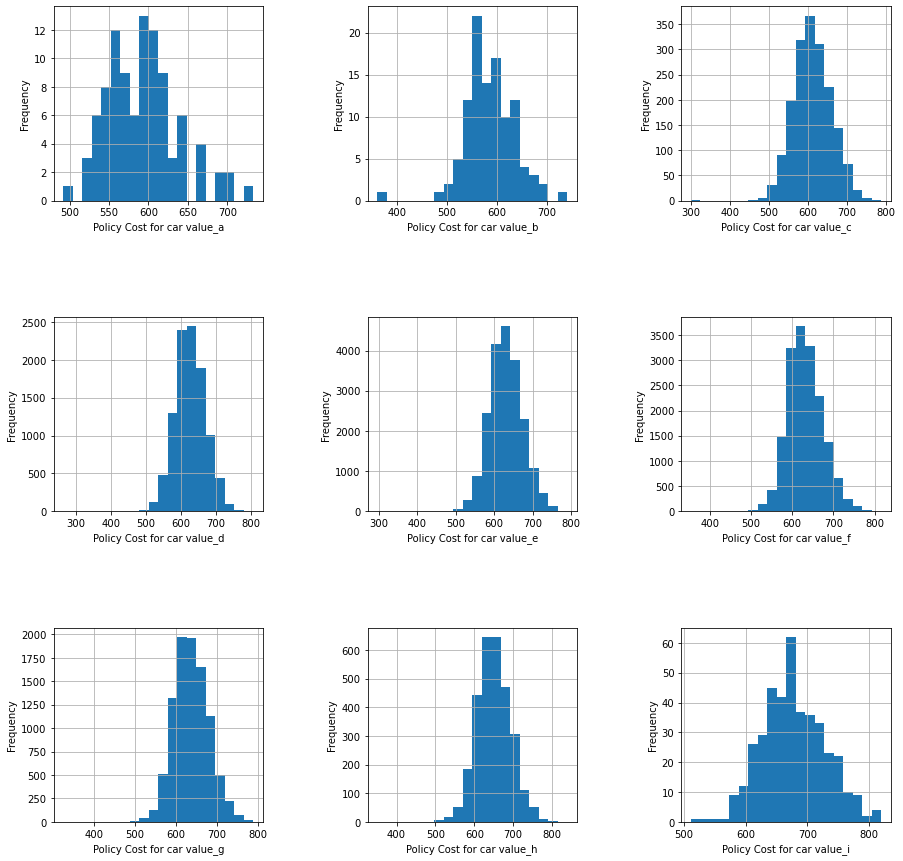

In [14]:

policy_cost_summary_stats_by_car_value = pd.DataFrame()

car_value = ['a','b','c','d','e','f','g','h','i']

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,15), squeeze=False)
fig.subplots_adjust(wspace=0.5, hspace=0.6)
ax = axes.flatten()

i=0

for value in car_value:
    df_car_value = df_all_na_removed[df_all_na_removed['car_value']== value]
    df_car_value.cost.hist(ax=ax[i],bins = 20)
    ax[i].set(xlabel='Policy Cost for car value_'+value, ylabel='Frequency')
    policy_cost_summary_stats_by_car_value["car_value_"+value] = df_car_value.cost.describe() 
    i += 1


    

In [15]:
policy_cost_summary_stats_by_car_value

car_value_a  car_value_b  car_value_c   car_value_d   car_value_e  \
count    97.000000   106.000000  1796.000000  10226.000000  20192.000000   
mean    592.742268   586.179245   610.772272    627.228535    630.204586   
std      44.918045    50.033474    48.194857     43.826413     43.224389   
min     492.000000   360.000000   301.000000    263.000000    295.000000   
25%     559.000000   555.000000   578.750000    598.000000    600.000000   
50%     592.000000   585.500000   608.000000    626.000000    629.000000   
75%     614.000000   614.750000   643.000000    655.000000    658.000000   
max     733.000000   741.000000   787.000000    808.000000    790.000000   

        car_value_f  car_value_g  car_value_h  car_value_i  
count  16945.000000  9538.000000  2950.000000   405.000000  
mean     631.288876   637.919165   649.246102   677.392593  
std       42.438224    42.143591    43.209150    51.382582  
min      354.000000   325.000000   350.000000   511.000000  
25%      602.000000   608.000000   620.000000   641.000000  
50%      628.000000   636.000000   648.000000   674.000000  
75%      659.000000   666.000000   678.000000   712.000000  
max      816.000000   789.000000   839.000000   820.000000

In the above table and histogram analysis, one can infer that the mean and median policy cost trend higher
from car_value "a" to car_value "i". It is thus reasonable to assume that car_value categories "a" to "i"
**represent increasingly car values**, so we can replace them with the **integers 1 to 9.**
But before we do that, let's look at missing values and see which ones can be filled/imputed.

## Missing Values

There are missing value only in four of the 25 fields, these are:
    
1) **car_value**: 1531 missing values i.e. 0.2%.
    
2) **risk_factor**: 240,418 missing values, that's **36.1%**!

3) **C_previous**: 18711 missing values at 2.8%.

4) **duration_previous**: 18711 missing values at 2.8%.

Out of these, there are 3 fields (1,3,4 above) that are customer provided. The percentage missing values are relativively low. As we know that customers take multiple quotes, it is possible that some customers might have provided this information at a later point in their purchase process. If so, we can use that data to backfill the information for the earlier quotes. 
Let's check this out.


In [16]:
# Fill missing values of car_value, risk_factor, C_previous and duration_previous if they are available at some point in
# in the quote history

columns_with_missing_values =['car_value', 'risk_factor','C_previous', 'duration_previous']

for i, row in df_all.iterrows():
    if row['record_type'] == 1:
        start_index = i - (row['shopping_pt'] - 1)
        df_temp = df_all.loc[start_index:i,:]
        for column in columns_with_missing_values:
            if df_temp[column].isna().sum() > 0 and df_temp[column].isna().sum() < row['shopping_pt']:
                df_temp[column].fillna(method='backfill', inplace = True)
                if df_temp[column].isna().sum() > 0:
                    df_temp[column].fillna(method='ffill', inplace = True)

C:\Users\amite\Anaconda3\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [17]:
df_all.isna().sum()

customer_ID               0
shopping_pt               0
record_type               0
day                       0
time                      0
state                     0
location                  0
group_size                0
homeowner                 0
car_age                   0
car_value                 0
risk_factor          230643
age_oldest                0
age_youngest              0
married_couple            0
C_previous             5079
duration_previous      5079
A                         0
B                         0
C                         0
D                         0
E                         0
F                         0
G                         0
cost                      0
dtype: int64

**100%** of car_value and **73%** of C_previous and duration_previous values have been filled using known information at some point in customer shopping history. However, risk_factor missing values still remain high.

Now let's assign values '1' through '9' to the car_values 'a' to 'i' as per earlier analysis and then save this df in a new file.


In [18]:
df_all['car_value'].replace(['a','b','c','d','e','f','g','h','i'],[1,2,3,4,5,6,7,8,9],inplace=True)

df_all.head(12).T

0         1         2         3         4         5   \
customer_ID        10000000  10000000  10000000  10000000  10000000  10000000   
shopping_pt               1         2         3         4         5         6   
record_type               0         0         0         0         0         0   
day                       0         0         0         0         0         0   
time                  08:35     08:38     08:38     08:39     11:55     11:57   
state                    IN        IN        IN        IN        IN        IN   
location              10001     10001     10001     10001     10001     10001   
group_size                2         2         2         2         2         2   
homeowner                 0         0         0         0         0         0   
car_age                   2         2         2         2         2         2   
car_value                 7         7         7         7         7         7   
risk_factor             3.0       3.0       3.0       3.0       3.0       3.0   
age_oldest               46        46        46        46        46        46   
age_youngest             42        42        42        42        42        42   
married_couple            1         1         1         1         1         1   
C_previous              1.0       1.0       1.0       1.0       1.0       1.0   
duration_previous       2.0       2.0       2.0       2.0       2.0       2.0   
A                         1         1         1         1         1         1   
B                         0         0         0         0         0         0   
C                         2         2         2         2         2         2   
D                         2         2         2         2         2         2   
E                         1         1         1         1         1         1   
F                         2         2         2         2         2         2   
G                         2         1         1         1         1         1   
cost                    633       630       630       630       630       638   

                         6         7         8         9         10        11  
customer_ID        10000000  10000000  10000000  10000005  10000005  10000005  
shopping_pt               7         8         9         1         2         3  
record_type               0         0         1         0         0         0  
day                       0         0         0         3         3         3  
time                  11:58     12:03     12:07     08:56     08:56     08:57  
state                    IN        IN        IN        NY        NY        NY  
location              10001     10001     10001     10006     10006     10006  
group_size                2         2         2         1         1         1  
homeowner                 0         0         0         0         0         0  
car_age                   2         2         2        10        10        10  
car_value                 7         7         7         5         5         5  
risk_factor             3.0       3.0       3.0       4.0       4.0       4.0  
age_oldest               46        46        46        28        28        28  
age_youngest             42        42        42        28        28        28  
married_couple            1         1         1         0         0         0  
C_previous              1.0       1.0       1.0       3.0       3.0       3.0  
duration_previous       2.0       2.0       2.0      13.0      13.0      13.0  
A                         1         1         1         1         1         1  
B                         0         0         0         1         1         1  
C                         2         2         2         3         3         3  
D                         2         2         2         3         3         3  
E                         1         1         1         1         1         1  
F                         2         2         2         0         0         0 

In [43]:

datapath = "WIP_data"

save_file(df_all, 'data_with_filled_missing_vals.csv', datapath)


Writing file.  "WIP_data\data_with_filled_missing_vals.csv"


**risk_factor** seems to be a variable assigned by Allstate to the customer. It's value could be based on the information provided by the customer, or it could be an independently accessed factor.
Let us see if we can build a model for risk_factor based on available customer information fields. If a highly accurate model cab be built, then we can impute missing values using this model. Otherwise, we can leave this field blank.
For building the model, we will take only the observations will no missing values.


In [20]:

df_all_na_removed = df_all.dropna(how='any')

df_all_na_removed = df_all_na_removed[df_all_na_removed['record_type']==1]

df_all_na_removed.shape


(63067, 25)

In [21]:
customer_info = ['group_size','homeowner','car_age','car_value','risk_factor',\
                 'age_oldest','age_youngest', 'married_couple','C_previous','duration_previous']

df_known_cust_info = df_all_na_removed.loc[:, customer_info]

df_known_cust_info.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 63067 entries, 8 to 665242
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   group_size         63067 non-null  int64  
 1   homeowner          63067 non-null  int64  
 2   car_age            63067 non-null  int64  
 3   car_value          63067 non-null  int64  
 4   risk_factor        63067 non-null  float64
 5   age_oldest         63067 non-null  int64  
 6   age_youngest       63067 non-null  int64  
 7   married_couple     63067 non-null  int64  
 8   C_previous         63067 non-null  float64
 9   duration_previous  63067 non-null  float64
dtypes: float64(3), int64(7)
memory usage: 5.3 MB


Let's take a **75-25** split for the train-test datasets. Then make a linear regression pipe to train a model and predict the 'risk_factor'.

In [22]:
X1_train, X1_test, y1_train, y1_test = train_test_split(df_known_cust_info.drop(columns='risk_factor'), 
                                                    df_known_cust_info.risk_factor, test_size=0.25, 
                                                    random_state=47)

X1_train.shape, X1_test.shape, y1_train.shape, y1_test.shape

((47300, 9), (15767, 9), (47300,), (15767,))

In [23]:
pipe = make_pipeline(
    StandardScaler(), 
    SelectKBest(f_regression,k='all'),
    LinearRegression()
)

hasattr(pipe, 'fit'), hasattr(pipe, 'predict')


(True, True)

In [24]:
pipe.fit(X1_train,y1_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k='all',
                             score_func=<function f_regression at 0x000001FDB0376280>)),
                ('linearregression', LinearRegression())])

In [25]:
y1_tr_pred = pipe.predict(X1_train)
y1_te_pred = pipe.predict(X1_test)

mean_absolute_error(y1_train, y1_tr_pred), mean_absolute_error(y1_test, y1_te_pred)


(0.8857409664783948, 0.8817544550619402)

The model has an absolute error of ~0.89. That means the 'risk_factor' values would be off by 1, which could create lot of deviations for a variable that takes values from 1 to 4.

Let's train the model using cross-validate and see if that improves the performance.

In [26]:
cv_results = cross_validate(pipe, X1_train, y1_train, cv=5)
cv_scores = cv_results['test_score']
cv_scores


array([0.11517826, 0.10944997, 0.13170212, 0.11780834, 0.12932709])

In [27]:
cv_scores.mean()

0.1206931549385964

The average test scores are pretty low at 0.121. We are using all features to train the model. Let's see if using less features makes it work better. 

In [28]:
pipe5 = make_pipeline(
    StandardScaler(), 
    SelectKBest(f_regression, k=5),
    LinearRegression()
)

pipe5.fit(X1_train,y1_train)

y1_tr_pred = pipe5.predict(X1_train)
y1_te_pred = pipe5.predict(X1_test)

print(mean_absolute_error(y1_train, y1_tr_pred), mean_absolute_error(y1_test, y1_te_pred))

cv_results = cross_validate(pipe5, X1_train, y1_train, cv=5)
cv_scores = cv_results['test_score']
print(cv_scores.mean())



0.8876813877793527 0.8836535785802534
0.11552959711161018


In [29]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'selectkbest', 'linearregression', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize', 'linearregression__positive'])

In [30]:

k = [k+1 for k in range(len(X1_train.columns))]
grid_params = {'selectkbest__k': k}

lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)
lr_grid_cv.fit(X1_train, y1_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(k='all',
                                                    score_func=<function f_regression at 0x000001FDB0376280>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9]})

In [31]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [32]:
lr_grid_cv.best_params_



{'selectkbest__k': 6}

The best model takes **6 features** instead of all 9. Let's use it to predict the 'risk_factor' values.

In [33]:
score_mean, score_std

(array([0.09055621, 0.09316615, 0.10390234, 0.10540468, 0.1155296 ,
        0.12080832, 0.12077421, 0.12068574, 0.12069315]),
 array([0.00841121, 0.00830168, 0.00952095, 0.00908957, 0.00910837,
        0.0084543 , 0.00845203, 0.00849726, 0.00849574]))

In [34]:
y1_tr_pred = lr_grid_cv.best_estimator_.predict(X1_train)
y1_tr_pred

array([2.09010382, 2.65488473, 2.36774315, ..., 3.33406039, 2.80105632,
       2.74143644])

In [35]:
y1_te_pred = lr_grid_cv.best_estimator_.predict(X1_test)
y1_te_pred

array([2.37602831, 2.27615468, 2.85142681, ..., 2.62222853, 2.81582073,
       2.9828367 ])

In [36]:
# Predicted values are floating nos. Round them to nearest integer
y1_tr_pred_rounded = np.rint(y1_tr_pred)


y1_tr_pred_rounded

array([2., 3., 2., ..., 3., 3., 3.])

In [37]:
#Check predicted values against actual values. 

same_value = y1_tr_pred_rounded == y1_train
same_value.sum()


14103

In [38]:
same_value.sum() / y1_train.count()

0.29816067653276956

Only **29.8%** of the risk_factor values in **training set** were predicted correctly. That's quite low!
Let's see how it works with the test set.

In [39]:
y1_te_pred_rounded = np.rint(y1_te_pred)

same_value = y1_te_pred_rounded == y1_test
print(same_value.sum())
print(same_value.sum() / y1_test.count())

4791
0.30386249762161477


The values predicted correctly in test set are also very similar at **30.4%**. This is better than using the 
median value of 3 that represents 27% of values, but it is still quite low. 
Let's us try some other modelling algorithms like random forest.

In [19]:
#Define a pipeline comprising the steps:
#StandardScaler(),
#and then RandomForestRegressor() with a random state of 47
RF_pipe = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(random_state=47)
)

In [20]:
#Call `cross_validate` to estimate the pipeline's performance.
#Pass it the random forest pipe object, `X_train` and `y_train`,
#and get it to use 5-fold cross-validation
rf_default_cv_results = cross_validate(RF_pipe, X1_train, y1_train, cv=5)


In [21]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([ 0.02323628,  0.03068677, -0.00640292,  0.00910911,  0.01995497])

These test scores are **even lower** than the Linear Regression model!

In [51]:
n_est = [int(n) for n in np.logspace(start=2.8, stop=3.0, num=1)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None],
        }
grid_params


{'randomforestregressor__n_estimators': [630],
 'standardscaler': [StandardScaler(), None]}

In [52]:
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)
type(rf_grid_cv)


sklearn.model_selection._search.GridSearchCV

In [53]:
rf_grid_cv.fit(X1_train, y1_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=47))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [630],
                         'standardscaler': [StandardScaler(), None]})

In [54]:
rf_grid_cv.best_params_

{'randomforestregressor__n_estimators': 630, 'standardscaler': None}

In [55]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X1_train, y1_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([0.03031059, 0.03546232, 0.00313077, 0.01592548, 0.02422061])

In [56]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(0.021809953049630383, 0.011384183714309758)

**Predicting risk_factor - Conclusion**

The prediction of risk_factor using a model based on the 9 known consumer variables is not very accurate. So we will not use it.
Risk_factor is an ordinal assessment of how risky the consumer is and is made by the company. Allstate might be using the risk_factor to price the policy. The task of this project is to predict the product vector values that the consumer shall choose and that may or may not have a significant dependence on risk_factor. So let's retain the observations with missing risk_factor values for the EDA stage.

Now let's focus on how to organize the data for the EDA stage.


## Organizing the data

The original dataset is in the **long form**, with the shopping cycle of each customer contained in multiple rows, each row representing a particular quote. For each quote, the customer can change his/her information fields as well as choose different values for the product vector features 'A' through 'G'. This updated information/product vector selection could be vital in predicting the target and therefore it would be better to organize these fields for each quote as columns. This means we would need to organize the dataset in the **wide** form. 

Before we organize the data in the wide form, let us undestand which fields change as the customer moves through the shopping cycle. To ascertain this, we shall track changes to each field in a sub-set of the entire dataset. Fields that show changes can then be expanded in the wide form as columns.



In [44]:
df_all_new = pd.read_csv('WIP_data/data_with_filled_missing_vals.csv')

df_all_new.head(10).T

0         1         2         3         4         5  \
customer_ID        10000000  10000000  10000000  10000000  10000000  10000000   
shopping_pt               1         2         3         4         5         6   
record_type               0         0         0         0         0         0   
day                       0         0         0         0         0         0   
time                  08:35     08:38     08:38     08:39     11:55     11:57   
state                    IN        IN        IN        IN        IN        IN   
location              10001     10001     10001     10001     10001     10001   
group_size                2         2         2         2         2         2   
homeowner                 0         0         0         0         0         0   
car_age                   2         2         2         2         2         2   
car_value                 7         7         7         7         7         7   
risk_factor             3.0       3.0       3.0       3.0       3.0       3.0   
age_oldest               46        46        46        46        46        46   
age_youngest             42        42        42        42        42        42   
married_couple            1         1         1         1         1         1   
C_previous              1.0       1.0       1.0       1.0       1.0       1.0   
duration_previous       2.0       2.0       2.0       2.0       2.0       2.0   
A                         1         1         1         1         1         1   
B                         0         0         0         0         0         0   
C                         2         2         2         2         2         2   
D                         2         2         2         2         2         2   
E                         1         1         1         1         1         1   
F                         2         2         2         2         2         2   
G                         2         1         1         1         1         1   
cost                    633       630       630       630       630       638   

                          6         7         8         9  
customer_ID        10000000  10000000  10000000  10000005  
shopping_pt               7         8         9         1  
record_type               0         0         1         0  
day                       0         0         0         3  
time                  11:58     12:03     12:07     08:56  
state                    IN        IN        IN        NY  
location              10001     10001     10001     10006  
group_size                2         2         2         1  
homeowner                 0         0         0         0  
car_age                   2         2         2        10  
car_value                 7         7         7         5  
risk_factor             3.0       3.0       3.0       4.0  
age_oldest               46        46        46        28  
age_youngest             42        42        42        28  
married_couple            1         1         1         0  
C_previous              1.0       1.0       1.0       3.0  
duration_previous       2.0       2.0       2.0      13.0  
A                         1         1         1         1  
B                         0         0         0         1  
C                         2         2         2         3  
D                         2         2         2         3  
E                         1         1         1         1  
F                         2         2         2         0  
G                         1         1         1         2  
cost                    638       638       634       755

Now let's create a function that can track changes to a particular feature.

In [45]:
def check_changes(data_frame, var_list):
    """ check for how many customers the feature(s) changed duration shopping and final purchase cycle
    Track these changes using a dictionary of lists, with keys representing the feature and the list tracking 
    changes for each customer.
    """
    # initialize an empty dict
    changes_tracker = {}
    for var in var_list:
        changes_tracker[var] = []
    for i,row in data_frame.iterrows():
        if row['record_type'] == 1:
            total_quotes = row['shopping_pt']
            for var in var_list:
                quote_index = i - total_quotes + 2
                var_change_counter = 0
                while quote_index <= i:
                    if data_frame.loc[quote_index, var] != data_frame.loc[quote_index -1, var]:
                        var_change_counter += 1
                    quote_index += 1
                changes_tracker[var].append(var_change_counter)
                
    return changes_tracker

Let's check changes to state & location first.

In [46]:

customer_info = ['state','location']

track_changes = check_changes(df_all_new, customer_info)

for key in track_changes.keys():
    print(f'{key} : No. of Customers# - {len(track_changes[key])}, Customer with changes# - {np.count_nonzero(track_changes[key])}')
    


state : No. of Customers# - 97009, Customer with changes# - 0
location : No. of Customers# - 97009, Customer with changes# - 1492


Customers don't change state, but do seem to change their zipcode during the shopping process.
Let's track changes in all other features/vectors.

In [ ]:

customer_info = ['day', 'time','group_size','homeowner','car_age','car_value','risk_factor',\
                'age_oldest','age_youngest', 'married_couple','C_previous','duration_previous', \
                'A', 'B', 'C', 'D', 'E', 'F', 'G','cost']

track_changes = check_changes(df_all_new, customer_info)

In [91]:


for key in track_changes.keys():
    print(f'{key} : \t No. of Customers# - {len(track_changes[key])}, \t Customer with changes# - {np.count_nonzero(track_changes[key])}')
    


day : 	 No. of Customers# - 97009, 	 Customer with changes# - 45376
time : 	 No. of Customers# - 97009, 	 Customer with changes# - 97007
group_size : 	 No. of Customers# - 97009, 	 Customer with changes# - 3065
homeowner : 	 No. of Customers# - 97009, 	 Customer with changes# - 4431
car_age : 	 No. of Customers# - 97009, 	 Customer with changes# - 3724
car_value : 	 No. of Customers# - 97009, 	 Customer with changes# - 6695
risk_factor : 	 No. of Customers# - 97009, 	 Customer with changes# - 34720
age_oldest : 	 No. of Customers# - 97009, 	 Customer with changes# - 4493
age_youngest : 	 No. of Customers# - 97009, 	 Customer with changes# - 5457
married_couple : 	 No. of Customers# - 97009, 	 Customer with changes# - 1352
C_previous : 	 No. of Customers# - 97009, 	 Customer with changes# - 2350
duration_previous : 	 No. of Customers# - 97009, 	 Customer with changes# - 7584
A : 	 No. of Customers# - 97009, 	 Customer with changes# - 38221
B : 	 No. of Customers# - 97009, 	 Customer wit

So all these variables change for some customers. **day** and **product vector components 'A' to 'G'** have the highest tendency to change. 
So barring state, we can expand all other fields into the wide form. Let's create a function to do this.

In [47]:
def expand_horizontal(data_main, data_final, cols):
    """ Takes quote history from data_main and expands it horizontally in data_final
        The variable in first quote is denoted with the nomenclature '_q_1',
        second quote with the nomenclature '_q_2' and so on."""
    
    for i,row in data_final.iterrows():
        start_index = i - (row['shopping_pt'] - 1)
        quote_num = 1
        while start_index < i:
            for column in cols:
                data_final.loc[i,column+'_q_'+str(quote_num)] =  data_main.loc[start_index,column]

            start_index += 1
            quote_num +=1
    
    return data_final

In [48]:

quote_info = ['day', 'time','location','group_size','homeowner','car_age','car_value','risk_factor',\
                'age_oldest','age_youngest', 'married_couple','C_previous','duration_previous', \
                'A', 'B', 'C', 'D', 'E', 'F', 'G','cost']


df_final_quote = df_all_new[df_all_new['record_type']==1]

df_final_quote = expand_horizontal(df_all_new,df_final_quote,quote_info)



C:\Users\amite\Anaconda3\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\Users\amite\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\amite\Anaconda3\lib\site-packages\pandas\core\indexing.py:1684: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

Let's check how the expanded dataset looks like.

In [49]:
df_final_quote.tail()

customer_ID  shopping_pt  record_type  day   time state  location  \
665225     10152718            9            1    2  10:36    FL     11018   
665233     10152720            8            1    4  08:34    FL     14100   
665239     10152721            6            1    4  10:14    CT     11888   
665242     10152723            3            1    1  10:30    FL     10711   
665248     10152724            6            1    1  15:14    KY     10204   

        group_size  homeowner  car_age  ...  C_previous_q_12  \
665225           2          1        1  ...              NaN   
665233           1          0       13  ...              NaN   
665239           1          0        8  ...              NaN   
665242           1          1        0  ...              NaN   
665248           1          1        1  ...              NaN   

        duration_previous_q_12  A_q_12  B_q_12  C_q_12  D_q_12  E_q_12  \
665225                     NaN     NaN     NaN     NaN     NaN     NaN   
665233                     NaN     NaN     NaN     NaN     NaN     NaN   
665239                     NaN     NaN     NaN     NaN     NaN     NaN   
665242                     NaN     NaN     NaN     NaN     NaN     NaN   
665248                     NaN     NaN     NaN     NaN     NaN     NaN   

        F_q_12  G_q_12  cost_q_12  
665225     NaN     NaN        NaN  
665233     NaN     NaN        NaN  
665239     NaN     NaN        NaN  
665242     NaN     NaN        NaN  
665248     NaN     NaN        NaN  

[5 rows x 277 columns]

In [50]:
datapath = "WIP_data"

save_file(df_final_quote, 'df_horizontal_expand.csv', datapath)

Writing file.  "WIP_data\df_horizontal_expand.csv"


## Summary


The data wrangling phase for the Allstate Insurance Product Vector project involved taking a close look at the available data file and performing a series of activities to clean the data and have it ready for further analysis. The findings and activities performed in this phase are enumerated below: 
 
**Step 1. Overall data structure and information available:** 
* The data file had information for 97009 customers across 665249 observations.
* The purchase cycle for each customer is contained across multiple observations, ranging from 3 to 13.
* Each observation for a customer corresponds to a particular quote that the customer took on the website
* The values for certain fields like 'car_value' and Product vectors are masked
* Based on detailed study of variables using the pandas-profiling tool, the variables were categorized as below:

             a) Numerical (6) - group_size, car_age, age_oldest and age_youngest, duration_previous & cost
             b) Datetime (1) - time
             c) Categorical (17) - customer_ID, shopping_pt, day, state, car_value, location, homeowner, risk_factor, married_couple, C_previous and 7 products vectors A to G
             d) Boolean (1) - record_type
    
**Step 2. Treating Missing Values** 
* Only 4 features had missing values -  car_value, risk_factor, C_previous, duration_previous
* 3 of these features are customer provided, and as customers take multiple quotes, it was possible that some customers might have provided this information at a later point in their purchase process.
* These 3 features were tracked for customers that had missing values. As a result, **100%** of the missing car_values and **73%** of the missing C_previous and duration_previous were found at some point in the customer's purchase cycle and this information was used to backfill the missing values. 
* This left only risk_factor with about **35%** missing values. The risk_factor is not a customer provided information, it is an independent assessment by Allstate. Some models were generated to predict risk_factor based on customer provided information, but these were only 30% accurate. As such, missing risk_factor values were not imputed. However, observations with missing risk_factor values were kept for the EDA stage, as the key goal of the project is to predict product vectors that the customer chooses and this may or maynot be correlated with risk_factor.

      
**Step 3. Organizing the data** 
* The dataset is organized in the **long form**, with a customer's purchase cycle spread across multiple observations
* Information provided and choices made by the customer at each step of the purchase cycle could be vital to predict the target
* As such, the information of different purchase points was expanded to the **wide form**, to make it easier to feed these changing fields into the prediction model. 
* It was found that all fields except 'state' change at some point in certain customer's purchase cycle. So all fields except 'state' were expanded into the wide form. 

The wide form of the dataset finalized for EDA stage has **97009 observations**, one for each customers across **277 columns**. 